# Simulação Modelo de Ising pelo Algoritmo de Metropolis
Arthur Souto Lima - 2018055113

### TODO:
- Refatorar função do erro
- Refatorar energia por spin e magnetização por spin

## Imports e Funções Auxiliares

Imports de funções das bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numba import jit

Importar funções auxiliares usadas em atividades anteriores para auxiliar nas computações.

In [2]:
from wang import (energy_ising, # calcula a energia da rede na configuração atual
                  neighbours,   # computa a matriz de vizinhança da rede
                  random_energy_state # cria uma configuração aleatória
                 )

In [3]:
from metropolis import metropolis   # simula modelo de Ising via Metropolis, 
                                    # com pequenas alterações com relação à atividade anterior

A função do algoritmo de Metropolis usado anteriormente foi levemente modificado para que possamos obter também o estado final naquela temperatura e usá-lo como inicial da temperatura seguinte, como orientado no enunciado.

### Processamento das Caixas (Bins) 

Obtidos os valores de energia e de magnetização, temos que separá-los em caixas (bins) e computar os valores necessários. Como pedido, o "primeiro bin" é descartado para fins de termalização.

In [4]:
def metropolis_bins(Energs, Mags, 
                    bin_size=10**5, 
                    total_mcs=1.1*10**6):
    """
    Obtém valores esperados simples e ao quadrado da energia e da magnetização
    da simulação do Modelo de Ising via Metropolis dentro de cada bin
    
    Parâmetros:
        Energs: array com as energias
        Mags: array com o módulo das magnetizações
        bin_size: tamanho da caixa, default 10**5
        total_mcs: quantidade total de passos de Monte Carlo, default 1.1e6
    
    Retornos:
        E : valor esperado de energia por bin
        E2: valor esperado de energia ao quadrado por bin
        M : valor esperado da magnetização por bin
        M2: valor esperado da magnetização ao quadrado por bin
    """
    # m: qtd de elementos por bin
    m = int(total_mcs / bin_size)
    
    # Descartar os primeiros 10**5, para fins de termalização
    Energs = Energs[bin_size:]
    Mags = Mags[bin_size:]
    assert(len(Energs) == (m-1)*bin_size)
    assert(len(Mags) == (m-1)*bin_size)
    m = m-1
    
    E = []  # Para guardar os E_j's
    E2 = []  # Para guardar os E^2_j's
    M = []  # Para guardar os M_j's
    M2 = []  # Para guardar os M^2_j's
    
    factor = 1/m
    for i in range(m):
        intervalE = np.array(Energs[i*m:(i+1)*m])
        intervalE2 = intervalE**2
        intervalM = np.array(Mags[i*m:(i+1)*m])
        intervalM2 = intervalM**2
              
        E.append(np.sum(factor * intervalE))
        E2.append(np.sum(factor * intervalE2))
        M.append(np.sum(factor * intervalM))
        M2.append(np.sum(factor * intervalM2))
        
    return E, E2, M, M2

### Propriedades Termodinâmicas

A seguir, são apresentados os algoritmos para computar os valores esperados e os erros associados a cada uma das grandezas pedidas no enunciado. São elas: calor específico, energia por spin, magnetização por spin e suscetibilidade magnética. 

#### Erro Estatístico Associado

O erro estatístico é sempre calculado da mesma forma, o que possibilita uma função genérica para tanto.

In [5]:
def error(ve, values):
    """
    Calcula o erro estatístico associado a uma grandeza.
    
    Parâmetros:
        ve: valor esperado da grandeza
        values: array com os valores da grandeza obtidos
    Retornos:
        err: erro estatístico associado
    """
    acc = 0
    n_bins = len(values)
    for i in range(n_bins):
        acc += (ve - values[i])**2
    err = np.sqrt(acc/(n_bins*(n_bins-1)))
    return err

#### Calor Específico

In [6]:
def media_calor(E, E2, beta, N):
    """
    Computa o valor esperado do calor específico 
    e seu erro estatístico associado
    
    Parâmetros:
        E : valor esperado de energia por bin
        E2: valor esperado de energia ao quadrado por bin
        beta: inverso da temperatura (1/T)
        N: quantidade de sítios da rede (N=LxL)
    
    Retornos:
        ve_cv: valor esperado do calor específico
        err: erro estatístico associado
    """
    # Cálculo do valor esperado
    n_bins = len(E)
    cv = np.zeros(n_bins)
    factor = beta**2/N
    for i in range(n_bins):
        term = E2[i] - E[i]**2
        term = factor * term
        cv[i] = term
    ve_cv = np.sum(cv)/n_bins
    
    # Cálculo do erro
    err = error(ve_cv, cv)
    
    return ve_cv, err

#### Energia por Spin

In [7]:
def media_energia_spin(E, E2, N):
    """
    Computa o valor esperado da energia por spin 
    e seu erro estatístico associado
    
    Parâmetros:
        E : valor esperado de energia por bin
        E2: valor esperado de energia ao quadrado por bin
        N: quantidade de sítios da rede (N=LxL)
    
    Retornos:
        ve_eps: valor esperado da energia por spin 
        err: erro estatístico associado
    """
    # Cálculo do valor esperado
    n_bins = len(E)
    EpS = np.zeros(n_bins)
    factor = 1/N
    for i in range(n_bins):
        EpS[i] = factor * E[i]
    ve_eps = np.sum(EpS)/n_bins
    
    # Cálculo do erro
    err = error(ve_eps, EpS)
    
    return ve_eps, err

#### Magnetização por Spin

In [8]:
def media_magn_spin(M, M2, N):
    """
    Computa o valor esperado do módulo da magnetização por spin 
    e seu erro estatístico associado
    
    Parâmetros:
        M : valor esperado de magnetização por bin
        M2: valor esperado de magnetização ao quadrado por bin
        N: quantidade de sítios da rede (N=LxL)
    
    Retornos:
        ve_mags: valor esperado da mangnetização por spin
        err: erro estatístico associado
    """
    # Cálculo do valor esperado
    n_bins = len(E)
    MagS = np.zeros(n_bins)
    factor = 1/N
    for i in range(n_bins):
        MagS[i] = factor * M[i]
    ve_mags = np.sum(MagS)/n_bins
    
    # Cálculo do erro
    err = error(ve_mags, MagS)
    
    return ve_mags, err

#### Susceptibilidade Magnética

In [9]:
def media_susceptibilidade(M, M2, beta, N):
    """
    Computa o valor esperado da susceptibilidade magnética
    e seu erro estatístico associado
    
    Parâmetros:
        M : valor esperado de magnetização por bin
        M2: valor esperado de magnetização ao quadrado por bin
        N: quantidade de sítios da rede (N=LxL)
    
    Retornos:
        ve_ssm: valor esperado da susceptibilidade magnética
        err: erro estatístico associado
    """
    # Cálculo do valor esperado
    n_bins = len(E)
    ssm = np.zeros(n_bins)
    factor = beta/N
    for i in range(n_bins):
        term = M2[i] - M[i]**2
        term = factor * term
        ssm[i] = term
    ve_ssm = np.sum(ssm)/n_bins
    
    # Cálculo do erro
    err = error(ve_ssm, ssm)
    
    return ve_ssm, err

## Estrutura de Dados para os Resultados

A fim de facilitar a leitura, entendimento e desenvolvimento, escolheu-se agrupar todas as informações de uma determinada rede numa única estrutura de dados. Assim, todos os dados referentes à ela ficam juntas.

In [33]:
class redeIsing2D:
    """
    Classe para agrupar todas as informações de uma determinada rede no modelo de Ising.
    Isso inclui seu tamanho e suas propriedades termodinâmicas
    """
    
    def __init__(self, L):
        """Inicializa rede e aloca vetores para dados termodinâmicos"""
        # Dimensões da rede
        self.L = L
        self.N = L**2
        
        # Estado anterior do sistema, para iterações seguintes
        self.s_anterior = None    
        
        # Propriedades termodinâmicas e seus erros associados
        self.temps = []
        self.cal, self.cal_err = [], []
        self.ener, self.ener_err = [], []
        self.mag, self.mag_err = [], []
        self.sus, self.sus_err = [], []
    
    def reverse_data(self):
        """Inverte os arrays de propriedades termodinâmicas"""
        self.temps.reverse()
        self.cal.reverse()
        self.cal_err.reverse()
        self.ener.reverse()
        self.ener_err.reverse()     
        self.mag.reverse()
        self.mag_err.reverse()
        self.sus.reverse()
        self.sus_err.reverse()

In [12]:
redes = [redeIsing2D(18), 
         redeIsing2D(24), 
         redeIsing2D(36)]

## Simulações

Utilizando os algoritmos apresentados anteriormente, pode-se fazer a simulação de redes 18x18, 24x24 e 36x36. Seguiremos as orientações dadas e iniciaremos a simulação da temperatura mais alta, ou seja, 5 partindo de uma configuração aleatória. A cada etapa, diminuiremos a temperatura em 0.25 e partiremos da última configuração anterior.

In [13]:
step = 0.25
t_min = 1
t_max = 5

In [18]:
def prop_termo(r, E, E2, M, M2, temp, beta):
    """
    Calcula todas as propriedades termodinâmicas para a rede passada 
    na temperatura (e beta) informados.
    Os resultados são salvos na estrutura de dados da rede
    
    Parâmetros:
        r: a estrutura de dados que é a rede
        E : valor esperado de energia por bin
        E2: valor esperado de energia ao quadrado por bin
        M : valor esperado da magnetização por bin
        M2: valor esperado da magnetização ao quadrado por bin
        temp: temperatura do sistema
        beta: inverso da temperatura do sistema
    
    Retornos:
        Nenhum. O resultado é salvo na rede.
    """
    # Temperatura atual
    r.temps.append(temp)
    
    # Calor Específico
    cal, err = media_calor(E, E2, beta, r.N)
    r.cal.append(cal)
    r.cal_err.append(err)
    
    # Energia por Spin 
    energ, err = media_energia_spin(E, E2, r.N)
    r.ener.append(energ)
    r.ener_err.append(err)
    
    # Magnetização por Spin 
    mag, err = media_magn_spin(M, M2, r.N)
    r.mag.append(mag)
    r.mag_err.append(err)
    
    # Susceptibilidade Magnética 
    sus, err = media_susceptibilidade(M, M2, beta, r.N)
    r.sus.append(sus)
    r.sus_err.append(err)

In [24]:
# Criação das redes
redes = [redeIsing2D(18), 
         redeIsing2D(24), 
         redeIsing2D(36)]

In [25]:
prints = True
# Ir de 5 até 1, com passos de 0.25
for temp in np.arange(t_max,t_min-step,-step):
    beta = 1/temp
    if (prints): print(temp)
    
    for r in redes:
        if (prints): print(f"Rede {r.L}x{r.L}:", end =" ", flush=True)
        
        # Simulação da rede via Metropolis nessa temperatura
        result = metropolis(L=r.L, s=r.s_anterior, 
                            temp=temp, steps=1.1*10**6)
        Es, Mags, r.s_anterior = result
        if (prints): print("Metropolis, ", end =" ", flush=True)
        
        # Processando as caixas
        E, E2, M, M2 = metropolis_bins(Es, Mags)
        
        # Cálculo das propriedades termodinâmicas
        prop_termo(r, E, E2, M, M2, temp, beta)
        if (prints): print("Propriedades", flush=True)
        

5.0
Rede 18x18: Metropolis,  Propriedades
Rede 24x24: Metropolis,  Propriedades
Rede 36x36: Metropolis,  Propriedades
4.75
Rede 18x18: Metropolis,  Propriedades
Rede 24x24: Metropolis,  Propriedades
Rede 36x36: Metropolis,  Propriedades
4.5
Rede 18x18: Metropolis,  Propriedades
Rede 24x24: Metropolis,  Propriedades
Rede 36x36: Metropolis,  Propriedades
4.25
Rede 18x18: Metropolis,  Propriedades
Rede 24x24: Metropolis,  Propriedades
Rede 36x36: Metropolis,  Propriedades
4.0
Rede 18x18: Metropolis,  Propriedades
Rede 24x24: Metropolis,  Propriedades
Rede 36x36: Metropolis,  Propriedades
3.75
Rede 18x18: Metropolis,  Propriedades
Rede 24x24: Metropolis,  Propriedades
Rede 36x36: Metropolis,  Propriedades
3.5
Rede 18x18: Metropolis,  Propriedades
Rede 24x24: Metropolis,  Propriedades
Rede 36x36: Metropolis,  Propriedades
3.25
Rede 18x18: Metropolis,  Propriedades
Rede 24x24: Metropolis,  Propriedades
Rede 36x36: Metropolis,  Propriedades
3.0
Rede 18x18: Metropolis,  Propriedades
Rede 24x24

In [30]:
redes[0].cal

[0.024691358025266247,
 0.06153481481500247,
 0.1251467764060606,
 0.28154195011337046,
 0.3953950617284046,
 0.46282700807802024,
 0.43251358024690767,
 0.3935533108866392,
 0.40019753086419596,
 0.3036364964570094,
 0.2192592592592582,
 0.16761854595336084,
 0.18472222222222168,
 0.10928583023623381,
 0.08743301326017364,
 0.1415284019014393,
 0.09161086419753083]

In [31]:
redes[0].cal.reverse()

In [34]:
redes[0].reverse_data()

AttributeError: 'redeIsing2D' object has no attribute 'reverse_data'

ValueError: x, y, and format string must not be None

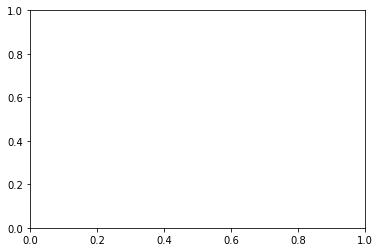

In [29]:
plt.plot(redes[0].cal.reverse())

In [ ]:
# Alocação de vetores para os dados
# cal: calor específico
# ener: energia por spin
# mag: magnetização por spin
# sus: susceptibilidade magnética

x_18, cal_18, ener_18, y3_18, y4_18, m_18 = [], [], [], [], [], []
x_24, cal_24, ener_24, y3_24, y4_24, m_24 = [], [], [], [], [], []
x_36, cal_36, ener_36 , y3_36 , y4_36 , m_36  = [], [], [], [], [], []

In [5]:
Es, mags, s = metropolis(L=18, temp=5, steps=1.1*10**6)

In [57]:
E, E2, M, M2 = metropolis_bins(Es, mags)

In [89]:
media_calor(E, E2, 1/5, 18**2)

(0.06477827160493806, 0.006827297892881646)

In [87]:
media_energia_spin(E, E2, 18**2)

(-0.43506172839506174, 0.012268897035856636)

In [85]:
media_magn_spin(M, M2, 18**2)

(0.07123456790123459, 0.006620400347184333)

In [83]:
media_suscetibilidade(M, M2, 1/5, 18**2)

(0.15233580246913583, 0.024049749224722076)